In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pyerrors as pe
import scipy.optimize
from scipy.linalg import cholesky
from scipy.stats import norm

In [2]:
plt.style.use('./base_style.mplstyle')
import shutil
usetex = shutil.which('latex') not in ('', None)
plt.rc('text', usetex=usetex)

Read data from the pcac example

In [3]:
fP = pe.Corr(pe.input.json.load_json("./data/f_P"), padding=[1, 1])
fP.gamma_method()

Data has been written using pyerrors 2.0.0.
Format version 0.1
Written by fjosw on 2022-01-06 11:27:34 +0100 on host XPS139305, Linux-5.11.0-44-generic-x86_64-with-glibc2.29

Description:  SF correlation function f_P on a test ensemble


We can now define a custom fit function, in this case a single exponential. __Here we need to use the autograd wrapped version of np__  (imported as anp) to use automatic differentiation.

In [4]:
import autograd.numpy as anp
def func_exp(a, x):
    y = a[1] * anp.exp(-a[0] * x)
    return y

Fit single exponential to f_P. The kwarg `resplot` generates a figure which visualizes the fit with residuals.

Fit with 2 parameters
Method: Levenberg-Marquardt
`xtol` termination condition is satisfied.
chisquare/d.o.f.: 0.0023324250917750268
fit parameters [ 0.20362603 16.25660947]

 Goodness of fit:
χ²/d.o.f. = 0.002332
p-value   = 1.0000
Fit parameters:
0	 0.2036(92)
1	 16.3(1.3)



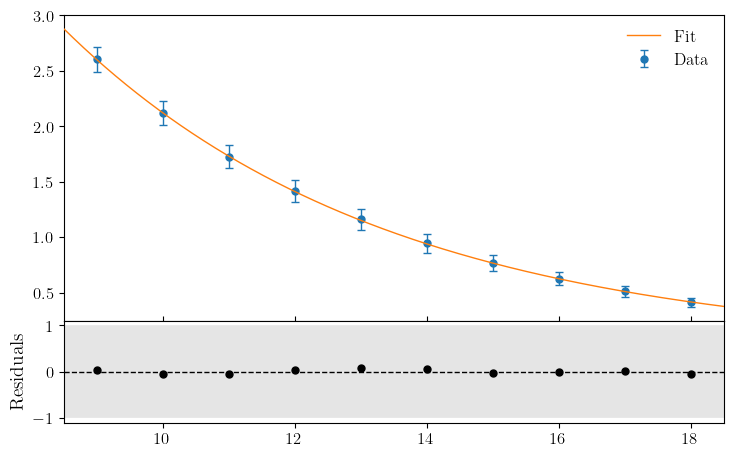

In [5]:
start_fit = 9
stop_fit = 18

fit_result = fP.fit(func_exp, [start_fit, stop_fit], resplot=True)
fit_result.gamma_method()
print("\n", fit_result)

The covariance of the two fit parameters can be computed in the following way

In [6]:
cov_01 = pe.fits.covariance([fit_result[0], fit_result[1]])[0, 1]
print('Covariance: ', cov_01)
print('Normalized covariance: ', cov_01 / fit_result[0].dvalue / fit_result[1].dvalue)

Covariance:  0.009831165600263978
Normalized covariance:  0.8384671240792649


## Effective mass

Calculate the effective mass for comparison

In [7]:
m_eff_fP = fP.m_eff()
m_eff_fP.tag = r"Effective mass of f_P"

Calculate the corresponding plateau and compare the two results

In [8]:
m_eff_fP.gamma_method()
m_eff_plateau = m_eff_fP.plateau([start_fit, stop_fit])
m_eff_plateau.gamma_method()
print()
print('Effective mass:\t', m_eff_plateau)
print('Fitted mass:\t', fit_result[0])

Fit with 1 parameter
Method: Levenberg-Marquardt
`ftol` termination condition is satisfied.
chisquare/d.o.f.: 0.13241808096938082
fit parameters [0.20567587]

Effective mass:	 0.2057(68)
Fitted mass:	 0.2036(92)


We can now visualize the effective mass compared to the result of the fit

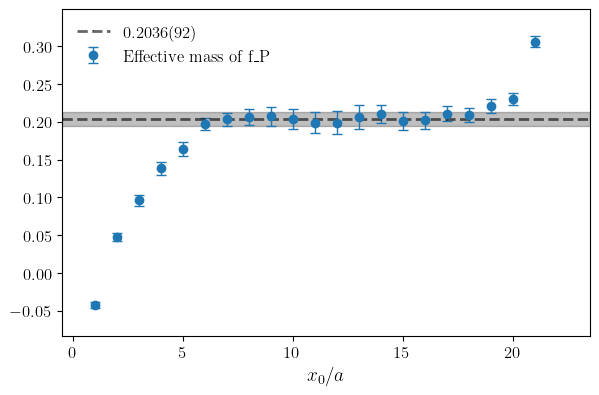

In [9]:
m_eff_fP.show(plateau=fit_result[0])

## Fitting with x-errors

We first generate pseudo data

In [10]:
ox = []
oy = []
for i in range(0,10,2):
    ox.append(pe.pseudo_Obs(i + 0.35 * np.random.normal(), 0.35, str(i)))
    oy.append(pe.pseudo_Obs(np.sin(i) + 0.25 * np.random.normal() - 0.2 * i + 0.17, 0.25, str(i)))

[o.gamma_method() for o in ox + oy]
[print(o) for o in zip(ox, oy)];

(Obs[-0.47(35)], Obs[-0.26(25)])
(Obs[2.44(35)], Obs[1.15(25)])
(Obs[3.68(35)], Obs[-1.23(25)])
(Obs[6.50(35)], Obs[-1.86(25)])
(Obs[7.91(35)], Obs[-0.32(25)])


And choose a function to fit

In [11]:
def func(a, x):
    y = a[0] + a[1] * x + a[2] * anp.sin(x)
    return y

We can then fit this function to the data and get the fit parameter as Obs with the function `odr_fit` which uses orthogonal distance regression.

In [12]:
beta = pe.fits.total_least_squares(ox, oy, func)

for i, item in enumerate(beta):
    item.gamma_method()
    print('Parameter', i + 1, ':', item)

Fit with 3 parameters
Method: ODR
Sum of squares convergence
Residual variance: 0.49296554803718634
Parameter 1 : 0.72(56)
Parameter 2 : -0.43(16)
Parameter 3 : 2.33(84)


For the visulization we determine the value of the fit function in a range of x values

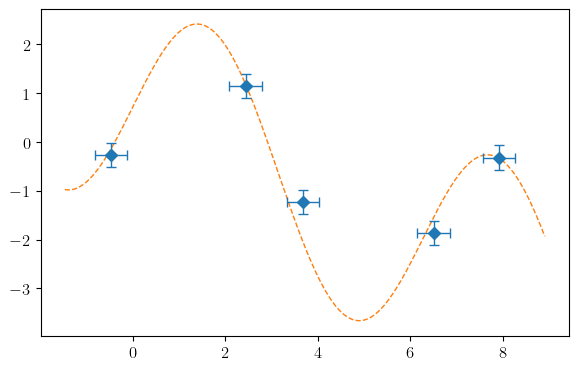

In [13]:
x_t = np.arange(min(ox).value - 1, max(ox).value + 1, 0.01)
y_t = func([o.value for o in beta], x_t)

plt.errorbar([e.value for e in ox], [e.value for e in oy], xerr=[e.dvalue for e in ox], yerr=[e.dvalue for e in oy], marker='D', lw=1, ls='none', zorder=10)
plt.plot(x_t, y_t, '--')
plt.show()

We can also take a look at how much the inidividual ensembles contribute to the uncetainty of the fit parameters

Parameter 0

Parameter 1

Parameter 2



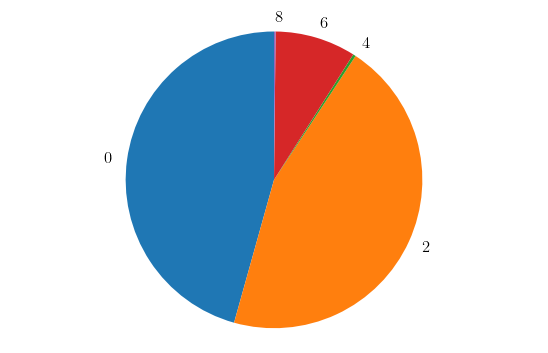

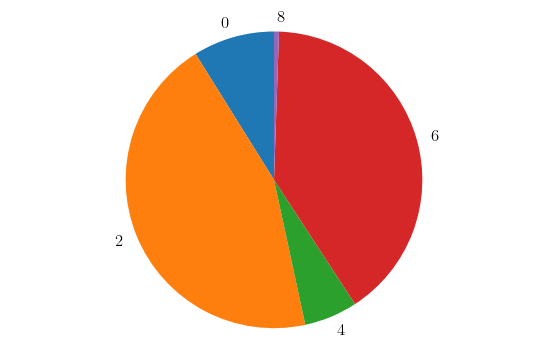

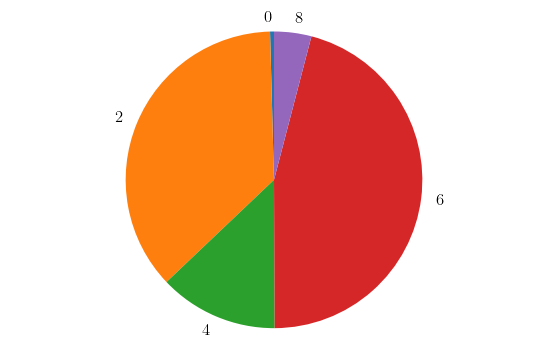

In [14]:
for i, item in enumerate(beta):
    print('Parameter', i)
    item.plot_piechart()
    print()

# Correlated fits with a covariance of your own choosing

##### generate a random data set

In [15]:
def fitf(p, x):
    return p[1] * anp.exp(-p[0] * x)

num_samples = 400
N = 10
x_random = norm.rvs(size=(N, num_samples)) # generate random numbers

r = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        r[i, j] = np.exp(-0.8 * np.fabs(i - j)) # element in correlation matrix

errl = np.sqrt([10.0, 2.5, 25.0, 2.8, 4.2, 4.7, 4.9, 5.1, 3.2, 4.2]) # set y errors
for i in range(N):
    for j in range(N):
        r[i, j] *= errl[i] * errl[j] # element in covariance matrix

c = cholesky(r, lower=True)
y = np.dot(c, x_random)
x = np.arange(N)


data = []
for i in range(N):
    data.append(pe.Obs([[np.exp(-(i + 1)) + np.exp(-(i + 1)) * o for o in y[i]]], ['ens']))

data[2] = data[2]+0.05

[o.gamma_method() for o in data]

corr = pe.covariance(data, correlation=True)
covdiag = np.diag(1 / np.asarray([o.dvalue for o in data]))

chol_inv = pe.obs.invert_corr_cov_cholesky(corr,covdiag)
chol_inv_keys = [""]

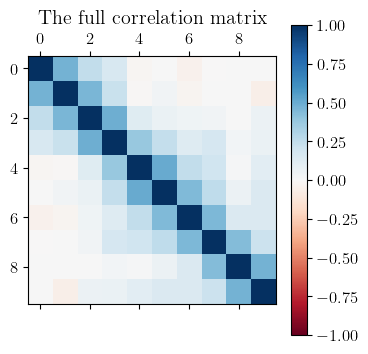

In [16]:
plt.matshow(corr, vmin=-1, vmax=1)
plt.title('The full correlation matrix')
plt.set_cmap('RdBu')
plt.colorbar()
plt.draw()

### generate a block diagonal covariance matrix

In [17]:
e=0
block_diag_corr_matrix = np.zeros((N,N))
for k in range(3):
    if(k==0):
        step = 4
        block =  pe.covariance(data[:4],correlation=True)
    else:
        step = 3
        block =  pe.covariance(data[:3],correlation=True)                        
    block_diag_corr_matrix[e:e+step,e:e+step] += block
    e+=step

block_diag_chol_inv = pe.obs.invert_corr_cov_cholesky(block_diag_corr_matrix,covdiag)

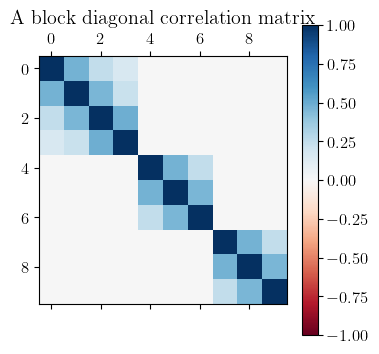

In [18]:
plt.matshow(block_diag_corr_matrix, vmin=-1, vmax=1)
plt.title('A block diagonal correlation matrix')
plt.set_cmap('RdBu')
plt.colorbar()
plt.draw()

#### perform a fully correlated fit and a fit with a block diagonal covariance matrix

In [19]:
fitpc = pe.least_squares(x, data, fitf, correlated_fit=True)
fitp_inv_block_diag_cov = pe.least_squares(x, data, fitf,  correlated_fit = True, inv_chol_cov_matrix = [block_diag_chol_inv,chol_inv_keys])

Fit with 2 parameters
Method: Levenberg-Marquardt
`ftol` termination condition is satisfied.
chisquare/d.o.f.: 2.3597637233070254
fit parameters [0.9754457  0.28547338]
Fit with 2 parameters
inv_chol_cov_matrix handed over as kwargs.
Method: Levenberg-Marquardt
`ftol` termination condition is satisfied.
chisquare/d.o.f.: 2.3217921000302923
fit parameters [0.9766841 0.2933594]


### generate a block diagonal covariance matrix with modified weights for particular data points + perform the fit again

In [20]:
covdiag[2][2] = covdiag[2][2]/100. # weight the third data point less
block_diag_chol_inv_weighted = pe.obs.invert_corr_cov_cholesky(block_diag_corr_matrix,covdiag)

fitp_inv_block_diag_cov_weighted = pe.least_squares(x, data, fitf,  correlated_fit = True, inv_chol_cov_matrix = [block_diag_chol_inv_weighted,chol_inv_keys])

Fit with 2 parameters
inv_chol_cov_matrix handed over as kwargs.
Method: Levenberg-Marquardt
`ftol` termination condition is satisfied.
chisquare/d.o.f.: 0.3401961132842267
fit parameters [0.99320618 0.33488345]


### compare the fully correlated fit to those with block-diagonal covariance matrices (and modified weights)

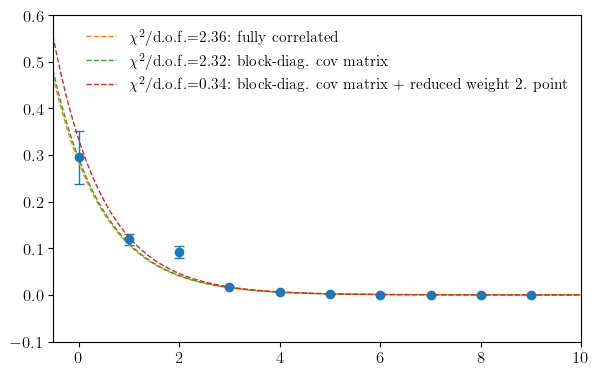

In [21]:
x_fit = np.arange(min(x) - 1, max(x)+ 1, 0.01)
y_fit_correlated = fitf([o.value for o in fitpc.fit_parameters], x_fit)
y_fit = fitf([o.value for o in fitp_inv_block_diag_cov.fit_parameters], x_fit)
y_fit_weighted = fitf([o.value for o in fitp_inv_block_diag_cov_weighted.fit_parameters], x_fit)

plt.figure()
plt.errorbar(x,data,yerr=[o.dvalue for o in data])
plt.plot(x_fit, y_fit_correlated, '--',label = '$\chi^2/\mathrm{d.o.f.}$=' + str(round(fitpc.chisquare/fitpc.dof,2)) +': fully correlated')
plt.plot(x_fit, y_fit, '--',label = '$\chi^2/\mathrm{d.o.f.}$=' + str(round(fitp_inv_block_diag_cov.chisquare/fitp_inv_block_diag_cov.dof,2)) +': block-diag. cov matrix')
plt.plot(x_fit, y_fit_weighted, '--',label = '$\chi^2/\mathrm{d.o.f.}$=' +str(round(fitp_inv_block_diag_cov_weighted.chisquare/fitp_inv_block_diag_cov_weighted.dof,2)) + 
                     ': block-diag. cov matrix + reduced weight 2. point')
plt.xlim(-0.5,10.0)
plt.ylim(-0.1,0.6)
plt.legend(fontsize=11)
plt.show()

- the fully correlated fit vs. the fit with a block diagonal covariance matrix
    - the fits do not differ significantly $\rightarrow$ the block diagonal covariance matrix can be a good estimator 
      (if a large fraction of the off-diagonal elements are small)\
      $\rightarrow$ sparser matrices can be more easily/cheaply inverted/saved 
- the fit with a block diagonal covariance matrix vs. the fit with " and a decreased weight for the third data point
    - the $\chi^2/\mathrm{d.o.f.}$ improves - decreasing/increasing the weights can be used for points that are known to be less/more 'trustworthy'